# Chaper 8 - Intrinsic Curiosity Module
#### Deep Reinforcement Learning *in Action*

##### Listing 8.1

In [1]:
from nes_py.wrappers import JoypadSpace #A
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #B
env = gym_super_mario_bros.make('SuperMarioBros-v3', apply_api_compatibility=True, render_mode="rgb_array")
env = JoypadSpace(env, COMPLEX_MOVEMENT) #C

/home/don/git/DeepReinforcementLearningInAction/venv/lib/python3.10/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()
/home/don/git/DeepReinforcementLearningInAction/venv/lib/python3.10/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [2]:
done = True
for step in range(2500): #D
    if done:
        state = env.reset()
    state, reward, done, trunc, info = env.step(env.action_space.sample())
    env.render()
#env.close()

/home/don/git/DeepReinforcementLearningInAction/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/don/git/DeepReinforcementLearningInAction/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


##### Listing 8.2

In [3]:
import matplotlib.pyplot as plt
from skimage.transform import resize #A
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #B
    else:
        return resize(obs, new_size, anti_aliasing=True)

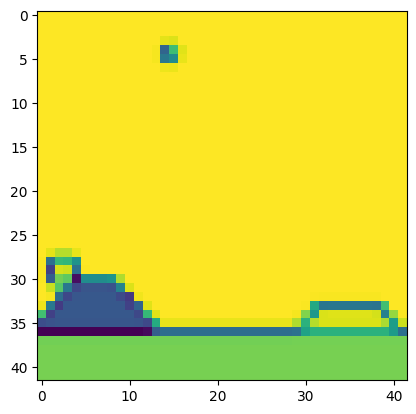

In [4]:
plt.imshow(env.render())
plt.imshow(downscale_obs(env.render()))

##### Listing 8.4

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): #A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)


def prepare_multi_state(state1, state2): #B
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1


def prepare_initial_state(state,N=3): #C
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N,1,1))
    return tmp.unsqueeze(dim=0)

##### Listing 8.5

In [6]:
def policy(qvalues, eps=None): #A
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=7,size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B

##### Listing 8.6

In [7]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N #A
        self.batch_size = batch_size #B
        self.memory = [] 
        self.counter = 0
        
    def add_memory(self, state1, action, reward, state2):
        self.counter +=1 
        if self.counter % 500 == 0: #C
            self.shuffle_memory()
            
        if len(self.memory) < self.N: #D
            self.memory.append( (state1, action, reward, state2) )
        else:
            rand_index = np.random.randint(0,self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2)
    
    def shuffle_memory(self): #E
        shuffle(self.memory)
        
    def get_batch(self): #F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        #G
        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False)
        batch = [self.memory[i] for i in ind] #batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

##### Listing 8.7

In [8]:
class Phi(nn.Module): #A
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) #size [1, 32, 3, 3] batch, channels, 3 x 3
        y = y.flatten(start_dim=1) #size N, 288
        return y

class Gnet(nn.Module): #B
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256)
        self.linear2 = nn.Linear(256,12)

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y,dim=1)
        return y

class Fnet(nn.Module): #C
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256)
        self.linear2 = nn.Linear(256,288)

    def forward(self,state,action):
        action_ = torch.zeros(action.shape[0],12) #D
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state,action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

##### Listing 8.8

In [9]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        #in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) #size N, 12
        return y

##### Listing 8.9

In [10]:
params = {
    'batch_size':150,
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0,
    'gamma':0.2,
    'max_episode_len':100,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #A
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

##### Listing 8.10

In [11]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss

def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render())
    return state1

##### Listing 8.11

In [12]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    state1_hat = encoder(state1) #A
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) #B
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, \
                        state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat) #C
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, \
                                        action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

##### Listing 8.12

In [13]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
    action_batch = action_batch.view(action_batch.shape[0],1) #A
    reward_batch = reward_batch.view(reward_batch.shape[0],1)
    
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #B
    i_reward = (1. / params['eta']) * forward_pred_err #C
    reward = i_reward.detach() #D
    if use_explicit: #E
        reward += reward_batch 
    qvals = Qmodel(state2_batch) #F
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack( (torch.arange(action_batch.shape[0]), \
    action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

##### Listing 8.13

In [ ]:
epochs = 5000
env.reset()
state1 = prepare_initial_state(env.render())
eps=0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = 0 #A
#ep_lengths = []
use_explicit = False
for i in range(epochs):
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1) #B
    if i > switch_to_eps_greedy: #C
        action = int(policy(q_val_pred,eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(params['action_repeats']): #D
        state2, e_reward_, done, trunc, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque),dim=1) #E
    replay.add_memory(state1, action, e_reward, state2) #F
    e_reward = 0
    if episode_length > params['max_episode_len']: #G
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done or trunc:
        #ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = 0
        episode_length = 0
    else:
        state1 = state2
    if len(replay.memory) < params['batch_size']:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False) #H
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #I
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(),\
    inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    loss.backward()
    opt.step()

/tmp/ipykernel_6414/227893001.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #B


In [18]:
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(500):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render())
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred,eps))
    state2, reward, done, trunc, info = env.step(action)
    state2 = prepare_multi_state(state1,state2)
    state1=state2
    env.render()